# _Set Up and Data Processing_

In [1]:
from capstone import data
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
torch.cuda.empty_cache()

In [3]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [5]:
# take 5% of data with a different seed than previous trail11
train_df, valid_df = data.data_processing(path, 'Atelectasis', 8, 1);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
Created sample dataframe with input seed.
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
Atelectasis
Training shape
(223414, 2)

Validation shape
(234, 2)


In [6]:
train_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00001/study1/...,0.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,-1.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,0.0


In [7]:
valid_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


# _U-Ignore_: Drop Uncertain (-1) Labels

In [8]:
train_df = train_df[train_df['Atelectasis'] != -1].reset_index(drop=True)
train_df['Atelectasis'] = train_df['Atelectasis'].astype(int)

In [9]:
train_df.head(10)

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00001/study1/...,0
1,CheXpert-v1.0-small/train/patient00002/study1/...,0
2,CheXpert-v1.0-small/train/patient00002/study1/...,0
3,CheXpert-v1.0-small/train/patient00003/study1/...,0
4,CheXpert-v1.0-small/train/patient00004/study1/...,0
5,CheXpert-v1.0-small/train/patient00004/study1/...,0
6,CheXpert-v1.0-small/train/patient00005/study1/...,0
7,CheXpert-v1.0-small/train/patient00005/study1/...,0
8,CheXpert-v1.0-small/train/patient00005/study2/...,0
9,CheXpert-v1.0-small/train/patient00005/study2/...,0


In [10]:
train_df.shape

(189675, 2)

# Set Up For DL Training

In [11]:
# default transformations
tfms = get_transforms()

In [12]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [13]:
src = src.split_by_rand_pct(0.1)

In [14]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 6324MB of GPU RAM free


In [15]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=64)
        .databunch(bs = bs)
        .normalize(imagenet_stats))
data.add_test(ImageList.from_df(valid_df, path=path, folder='.', suffix=''))

In [16]:
print(data.c)
print(data.classes)

2
[0, 1]


In [17]:
learn = cnn_learner(data=data, base_arch=models.resnet152, metrics=[error_rate, AUROC()], pretrained=True,
                     ps=0.5, bn_final=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.29E+00
Min loss divided by 10: 5.50E-01


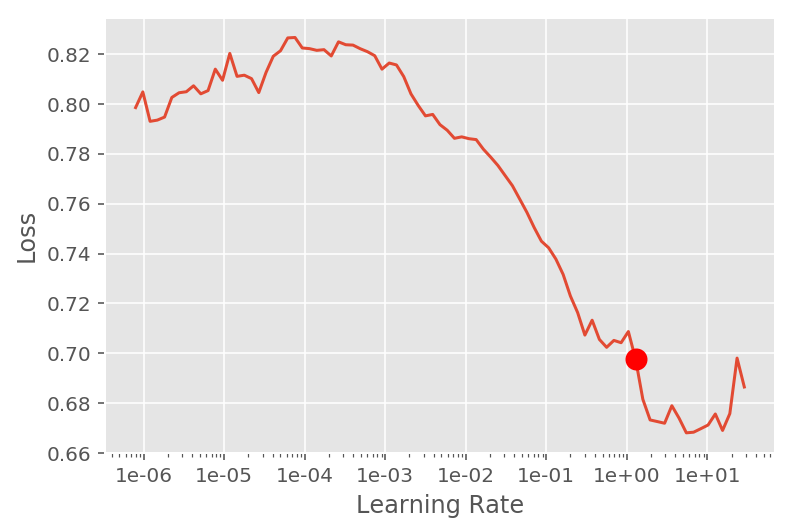

In [18]:
learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [19]:
lr = 1e-01
lr

0.1

# _Rd 1 Training_

In [20]:
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.469123,0.466934,0.170559,0.482727,28:06
1,0.454170,0.461052,0.170559,0.510650,27:54
2,0.450608,0.447836,0.170559,0.612556,28:11


In [22]:
interp = ClassificationInterpretation.from_learner(learn)

In [23]:
losses, idxs = interp.top_losses()

In [24]:
len(data.valid_ds) == len(losses) == len(idxs)

True

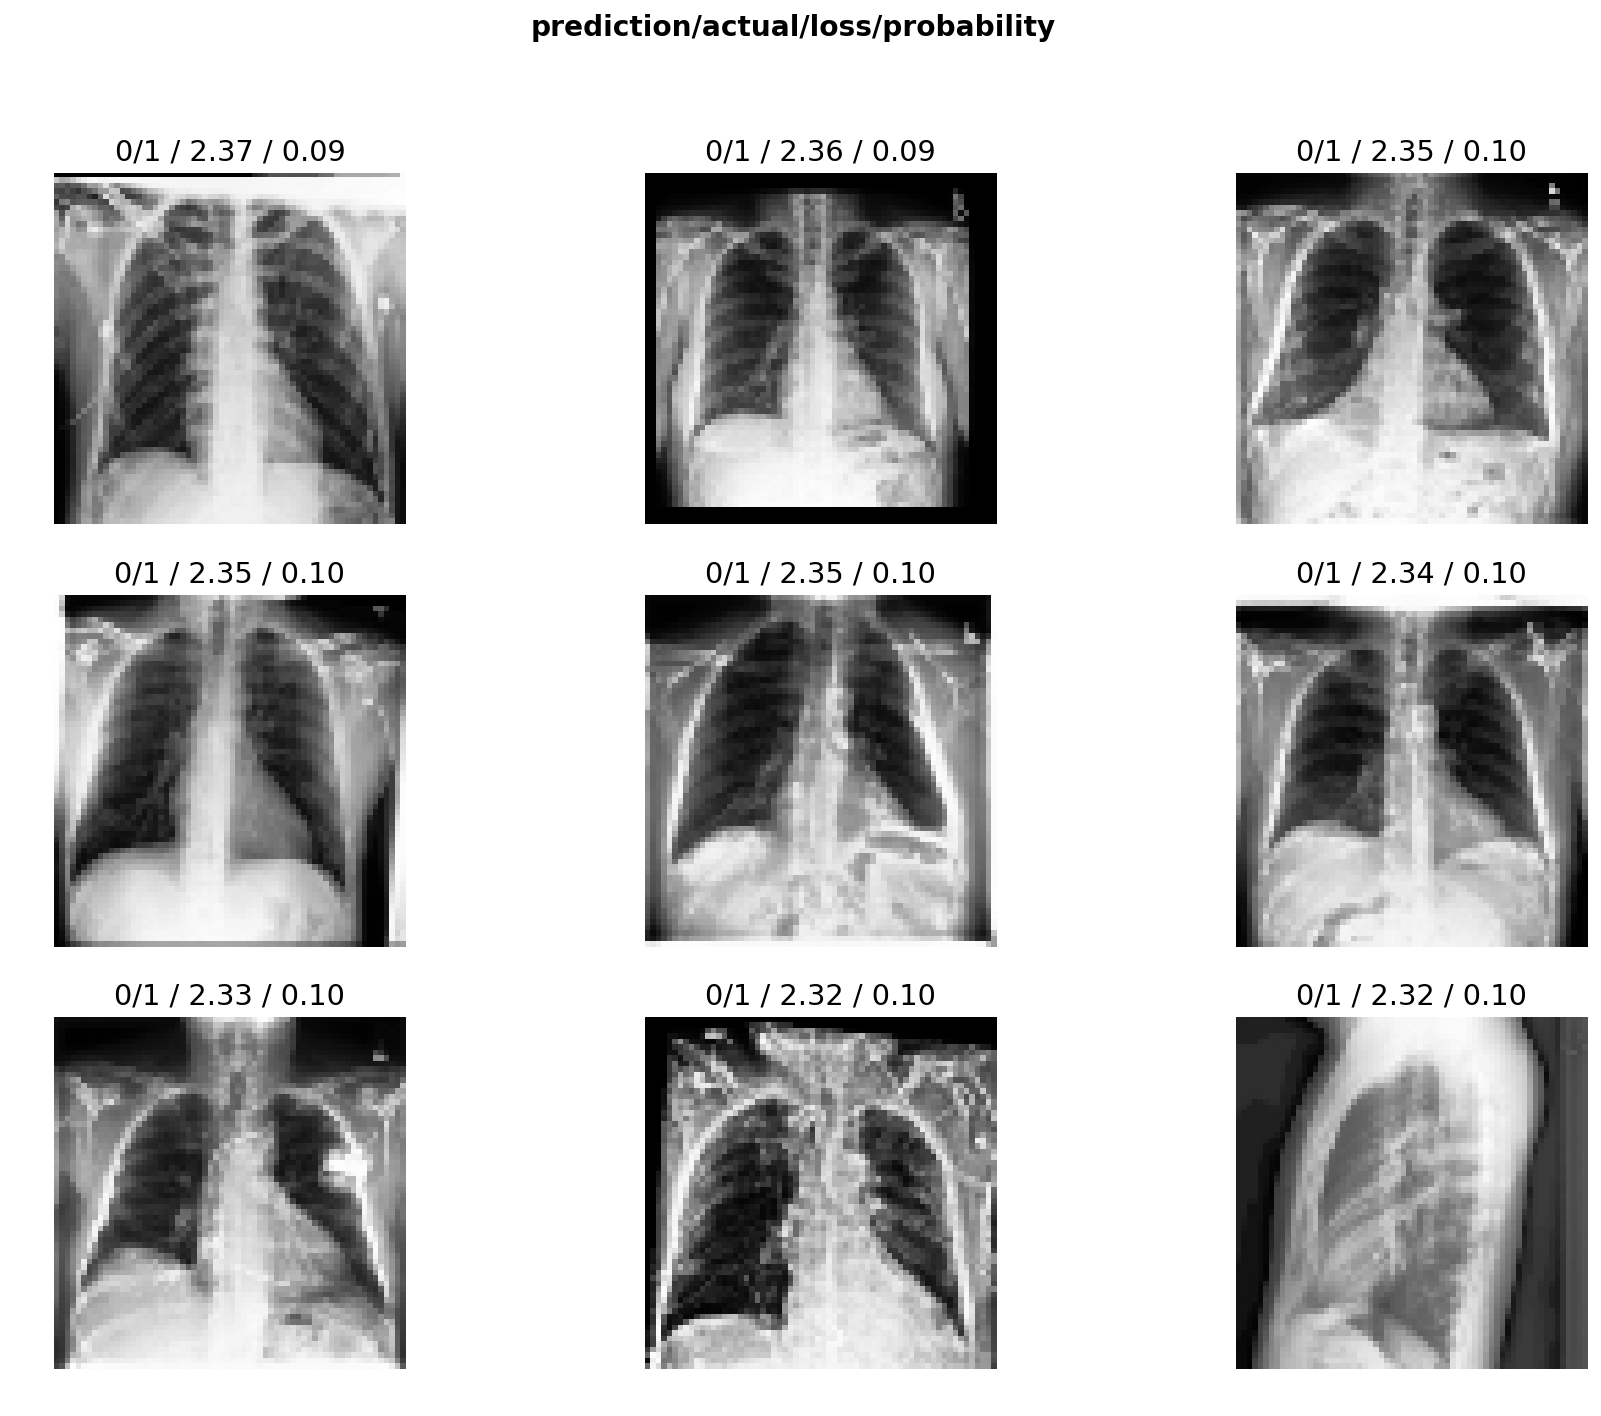

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

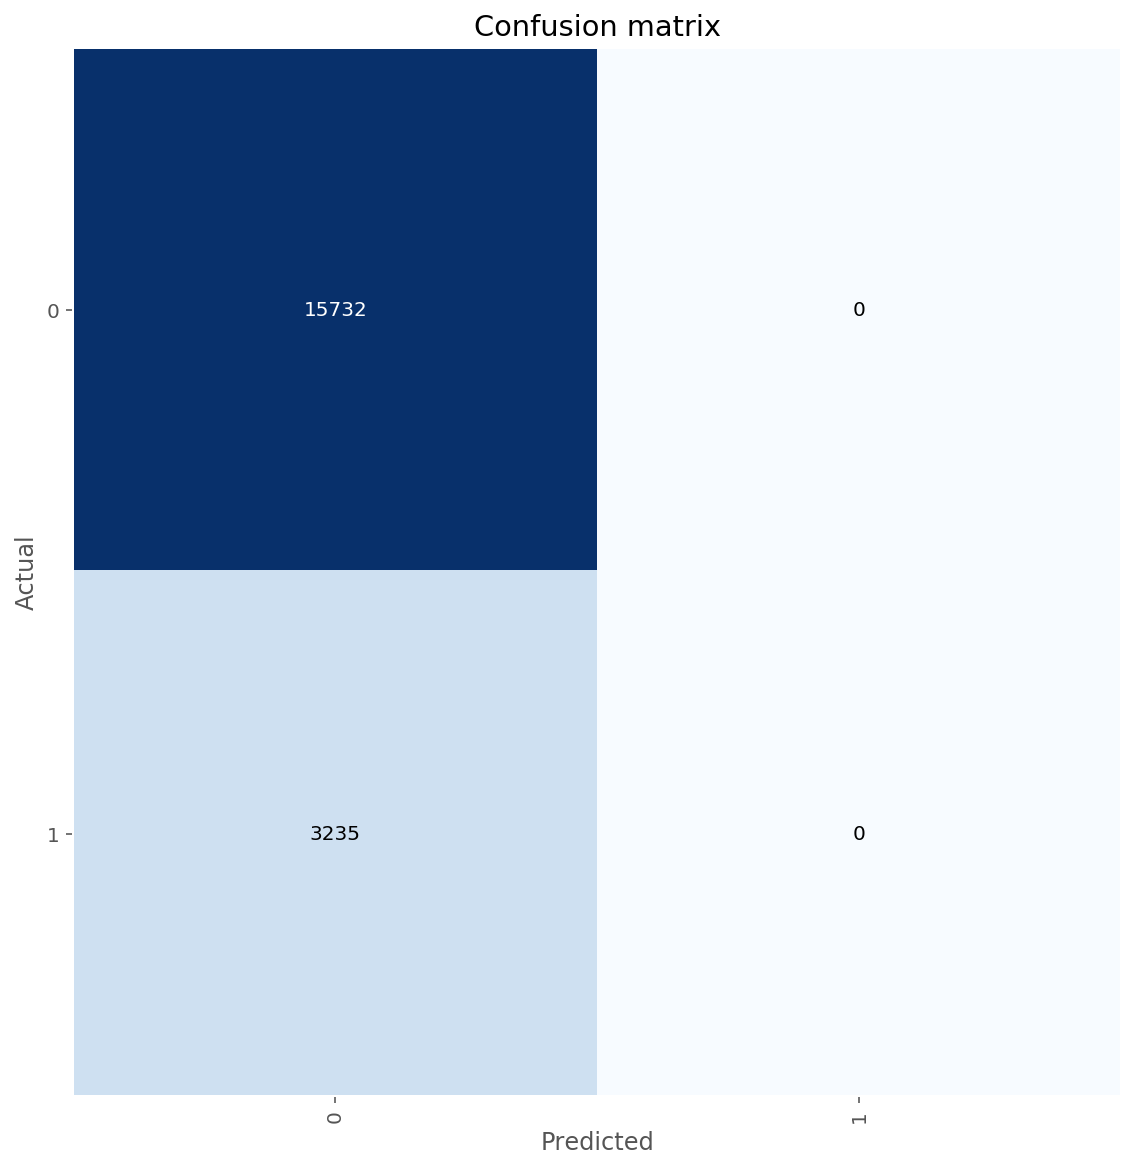

In [26]:
interp.plot_confusion_matrix(figsize=(8,8))

In [45]:
learn.save('trial14-rd1-atelectasis-fulldata')

# _Rd. 2 Training_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-07
Min loss divided by 10: 4.90E-05


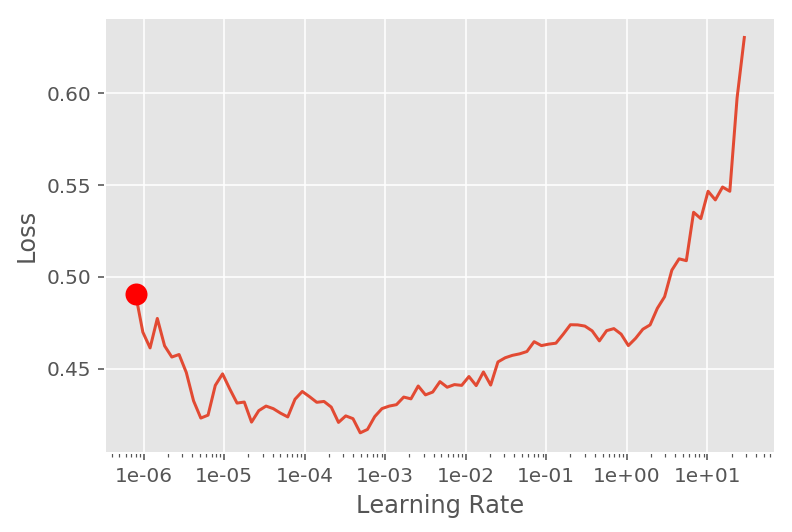

In [46]:
# unfreeze all layers
learn.unfreeze()

learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [48]:
x1 = (1e-05 + 1e-6) / 2
x2 = (1e-3 + 1e-4) / 2
print(x1, x2)

5.500000000000001e-06 0.00055


In [49]:
learn.fit_one_cycle(2, slice(x1, x2))

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.451151,0.445530,0.170559,0.616961,36:37
1,0.456570,0.444259,0.170559,0.627312,36:41


In [50]:
learn.save('trial14-rd2-atelectasis-fulldata')

# _Reconstructing data and launching -- Rd. 3 Training_

In [ ]:
# load previous weights
learn.load('trial14-rd2-atelectasis-fulldata');

In [36]:
tfms2 = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_rotate=359,
                     max_zoom=1.05, max_warp=0.1)

In [37]:
src2 = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [38]:
src2 = src.split_by_rand_pct(0.1)

In [39]:
data2 = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=128)
        .databunch(bs = bs)
        .normalize(imagenet_stats))
data2.add_test(ImageList.from_df(valid_df, path=path, folder='.', suffix=''))

In [ ]:
print(data.c)
print(data.classes)

In [ ]:
learn.data = data2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.82E-06
Min loss divided by 10: 3.16E-04


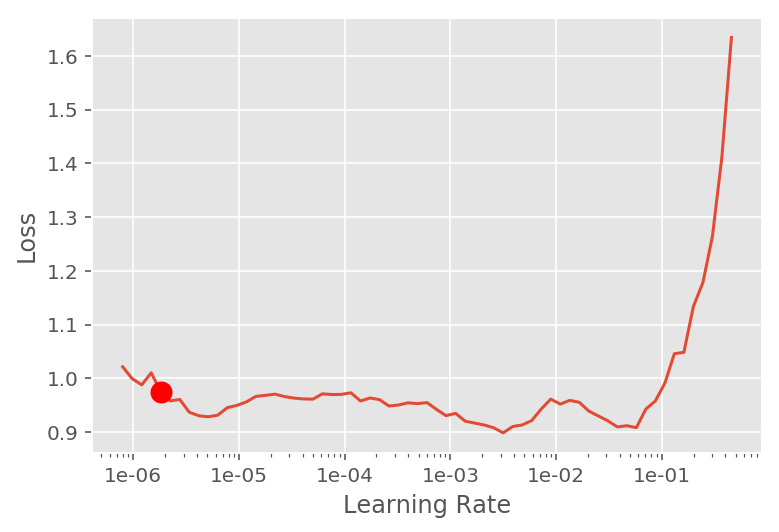

In [41]:
learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [42]:
#lr = 1e-03
#learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.562381,0.571253,0.759830,0.507419,02:21
1,0.479430,0.488116,0.822529,0.516455,02:22
2,0.475096,0.467476,0.822529,0.555254,02:22
3,0.473794,0.461080,0.822529,0.577156,02:22
4,0.439614,0.461270,0.822529,0.594872,02:22


In [43]:
# learn14.save('trial14-rd3-atelectasis-fulldata')

# _Unfreezing, fine-tuning, and learning rates_

In [44]:
# load previous weights
# learn.load('trial14-rd2-atelectasis-fulldata');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-05
Min loss divided by 10: 1.20E-07


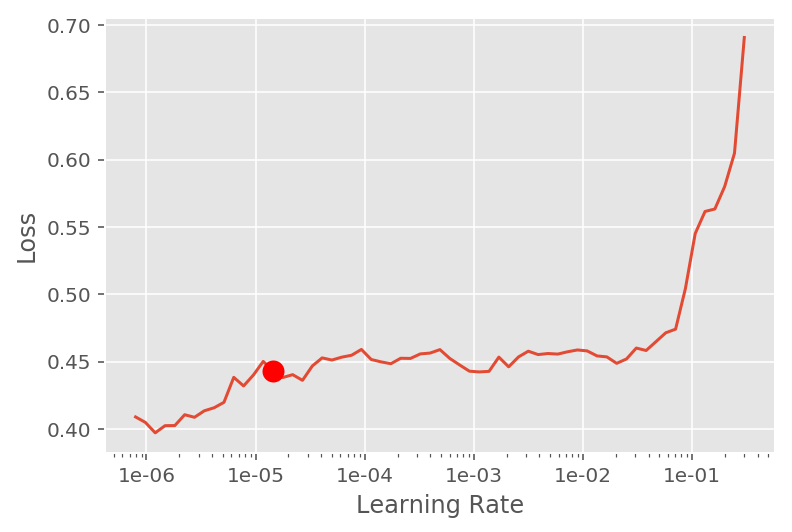

In [45]:
# learn.lr_find(start_lr=1e-7, end_lr=100)
# learn.recorder.plot(suggestion=True)

In [46]:
# unfreeze the model allowing pretrained weights to move around
#learn.unfreeze()

# lower layers change weights more slowly than higher layers
# learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.426796,0.472757,0.822529,0.593944,03:19
1,0.446563,0.459318,0.822529,0.602299,03:18


In [47]:
# learn.save('trial14-rd4-atelectasis-fulldata')